In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import Informer, LSTM, TFT, NHITS
from neuralforecast.losses.pytorch import MAE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from utilsforecast.plotting import plot_series
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
# Lista de tickets a procesar
tickets = ["AAPL", "AMZN", "TSLA", "GOOGL", "MSFT"]

# Inicializar una lista para almacenar los DataFrames
dfs = []
i = 0

# Iterar sobre cada ticket y cargar los datasets
for ticket in tickets:
    # Cargar el conjunto de datos para cada ticket
    df = pd.read_csv(f'../Data/{ticket}.csv', parse_dates=['Date'])
    
    # Añadir una columna 'unique_id' para identificar cada ticket
    df['unique_id'] = i
    i += 1
    # Agregar el DataFrame a la lista
    dfs.append(df)

# Unir todos los DataFrames en uno solo
df = pd.concat(dfs, ignore_index=True)

# Definir las características a utilizar
features = ['Open', 'High', 'Low', 'Close', 'Volume', 
            'SMA_50', 'SMA_200', 'RSI', 'MACD', 'MACD_signal']

# Filtrar el DataFrame con las columnas de interés
df_filt = df[['Date', 'unique_id'] + features]

# Asegurarse de que los datos estén ordenados por fecha
df_filt = df_filt.sort_values(by=['unique_id', 'Date'])

# Crear un índice de fechas completo para cada 'unique_id' (empresa)
full_idx = pd.date_range(start=df_filt['Date'].min(), end=df_filt['Date'].max(), freq='D')

# Reindexar el DataFrame para cada 'unique_id' e incluir todas las fechas
dfs_with_full_dates = []
for unique_id in df_filt['unique_id'].unique():
    # Filtrar por empresa
    df_ticker = df_filt[df_filt['unique_id'] == unique_id]
    
    # Crear un índice completo para esta empresa
    full_idx_ticker = pd.date_range(start=df_ticker['Date'].min(), end=df_ticker['Date'].max(), freq='D')
    
    # Reindexar el DataFrame para esta empresa e incluir todas las fechas
    df_ticker_reindexed = df_ticker.set_index('Date').reindex(full_idx_ticker).reset_index()
    df_ticker_reindexed.rename(columns={'index': 'Date'}, inplace=True)
    
    # Asignar el `unique_id` correctamente para los días faltantes
    df_ticker_reindexed['unique_id'] = unique_id  # Asignar el 'unique_id' a los días faltantes
    
    # Añadir la empresa reindexada a la lista
    dfs_with_full_dates.append(df_ticker_reindexed)

# Unir todos los DataFrames con las fechas completas
df_filt_full = pd.concat(dfs_with_full_dates, ignore_index=True)

# Imputar los valores faltantes en las columnas numéricas utilizando interpolación lineal
df_filt_full[features] = df_filt_full[features].interpolate(method='linear')

df_scaled = pd.DataFrame(df_filt_full[features], 
                         columns=features, 
                         index=df_filt_full.index)

# Reemplazar las columnas originales por las escaladas
df_filt_full[features] = df_scaled

# Renombrar columnas para el modelo
df = df_filt_full.rename(columns={'Date': 'ds', 'Close': 'y'})

df


,ds,unique_id,Open,High,Low,y,Volume,SMA_50,SMA_200,RSI,MACD,MACD_signal
0,2016-10-17,0,-1.304378,-1.308885,-1.301578,-1.305058,-0.136541,-1.318803,-1.300353,0.789199,-0.091212,-0.114770
1,2016-10-18,0,-1.304697,-1.307423,-1.298880,-1.301667,-0.067851,-1.317934,-1.300019,0.965019,-0.085876,-0.109277
2,2016-10-19,0,-1.306092,-1.309201,-1.313577,-1.305377,-0.402120,-1.317198,-1.299773,0.582632,-0.092378,-0.106274
3,2016-10-20,0,-1.306331,-1.310702,-1.303390,-1.306933,-0.099489,-1.316534,-1.299424,0.427217,-0.103392,-0.106229
4,2016-10-21,0,-1.308164,-1.312558,-1.303591,-1.307133,-0.168511,-1.315858,-1.299035,0.406515,-0.114864,-0.108649
...,...,...,...,...,...,...,...,...,...,...,...,...
14980,2024-12-26,4,1.909972,1.901040,1.934326,1.918867,-1.615373,1.880703,2.079398,-0.210211,0.762491,1.257890
14981,2024-12-27,4,1.844284,1.851882,1.844410,1.880042,-0.796098,1.884117,2.080159,-0.622016,0.567628,1.129140
14982,2024-12-28,4,1.827819,1.829910,1.831436,1.855372,-0.932568,1.884333,2.080248,-0.844787,0.449126,1.069270
14983,2024-12-29,4,1.811354,1.807938,1.818461,1.830702,-1.069038,1.884550,2.080337,-1.067558,0.330623,1.009400


In [4]:
# Dividir en conjunto de entrenamiento y prueba
train = df[df['ds'] <= '2024-09-30']
test = df[(df['ds'] > '2024-09-30')].reset_index(drop=True)


In [ ]:
# Inicializar el modelo Informer
models = Informer(
    h=7, 
    input_size=20,  
    hidden_size=128,
    conv_hidden_size=64,
    n_head=10,
    futr_exog_list = ['Open', 'High', 'Low', 'Volume', 'SMA_50', 'SMA_200', 'RSI', 'MACD', 'MACD_signal'],
    loss=MAE(),  # Usar el objeto de pérdida MAE
    scaler_type='robust',  # Tipo de escalado
    learning_rate=5e-4,  # Tasa de aprendizaje
    encoder_layers = 4,
    decoder_layers = 4,
    max_steps=200,  # Número máximo de pasos de entrenamiento
    val_check_steps=25,  # Validación cada 50 pasos
    batch_size = 128,
    dropout = 0.2
)

# Crear el objeto NeuralForecast y ajustar el modelo
nf = NeuralForecast(
    models=[model],
    freq='D'  # Frecuencia diaria
)

Seed set to 1


In [6]:
nf.fit(df=train)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 1.5 K  | train
4 | dec_embedding | DataEmbedding | 1.5 K  | train
5 | encoder       | TransEncoder  | 464 K  | train
6 | decoder       | TransDecoder  | 565 K  | train
--------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.133     Total estimated model params size (MB)
176       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.


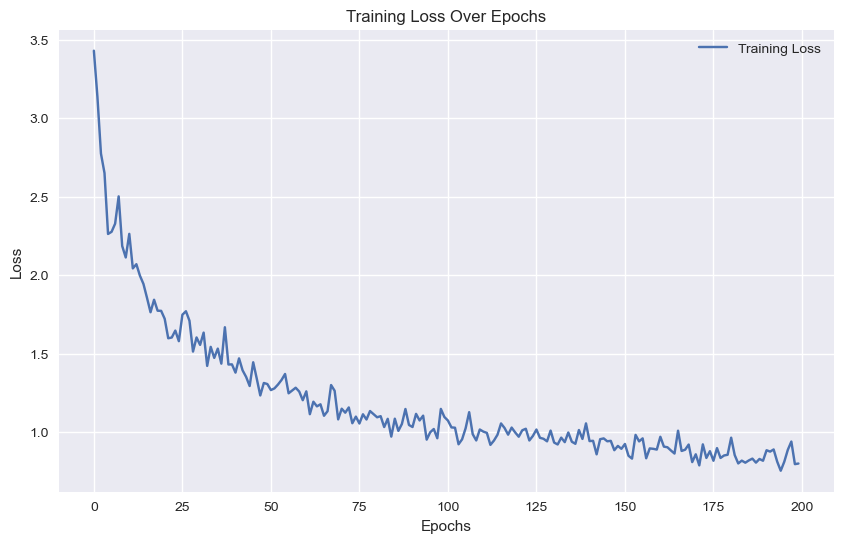

In [11]:
# Obtener el historial de pérdidas del modelo desde los resultados de entrenamiento
losses = nf.models[0].train_trajectories

# Extraer los valores de la pérdida y las épocas
epochs = [x[0] for x in losses]  # Épocas
train_loss = [x[1] for x in losses]  # Pérdidas

# Graficar las pérdidas de entrenamiento
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label="Training Loss")

# Añadir etiquetas y título
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

# Mostrar la gráfica
plt.show()

## Evaluación del Modelo

In [27]:
# Realizar predicciones utilizando el conjunto de prueba y las variables exógenas futuras
forecasts = nf.predict(futr_df=test)

c:\Users\pmyoe\anaconda3\Lib\site-packages\neuralforecast\core.py:904: UserWarning: Dropped 420 unused rows from `futr_df`.
  warnings.warn(f"Dropped {dropped_rows:,} unused rows from `futr_df`.")
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [13]:
y_test = test[(test['ds'] > '2024-09-30') & (test['ds'] <= '2024-10-07')]['y']

y_pred = forecasts['Informer'].values

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Imprimir las métricas
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2: {r2}')


MAE: 0.01899905651242749
MSE: 0.0006941753875110671
RMSE: 0.026347208343789803
R2: 0.9934891468736722


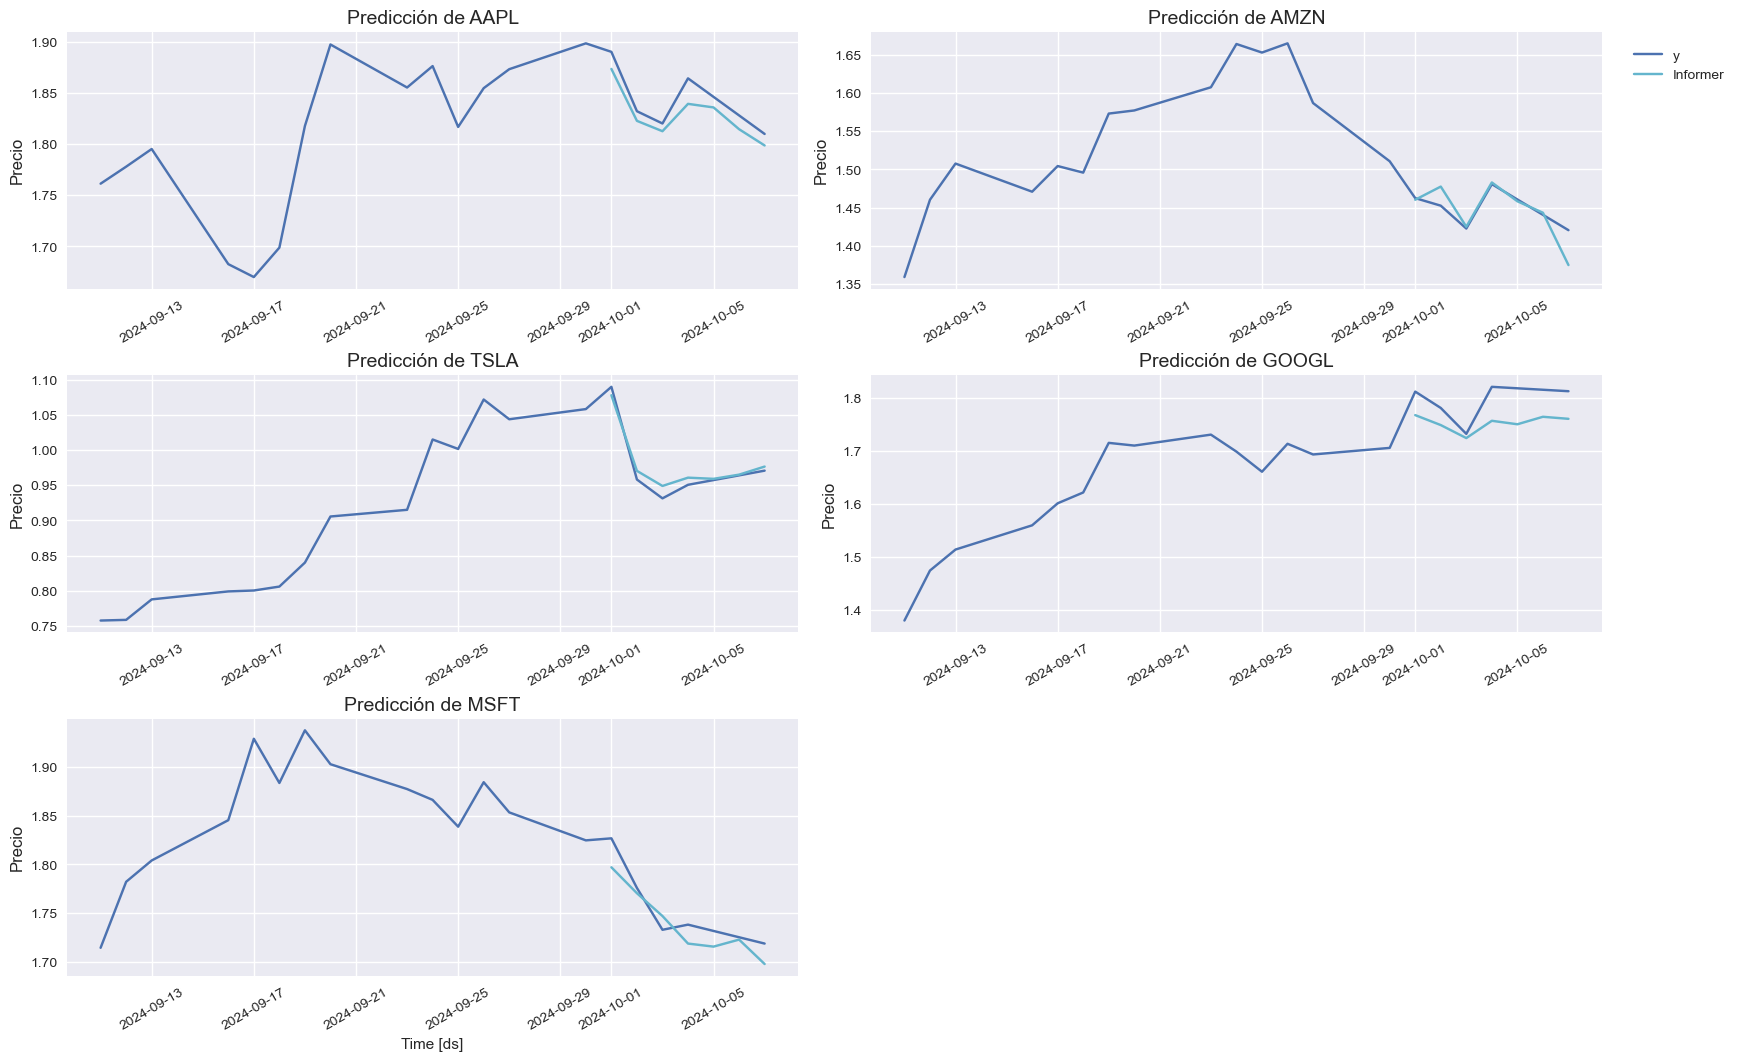

In [20]:
# Establecer el estilo de las gráficas
plt.style.use('seaborn-v0_8')

# Filtrar los datos para el rango de fechas especificado
df_filtered = df[(df['ds'] > '2024-09-10') & (df['ds'] <= '2024-10-07')]


# Graficar con plot_series (la función retorna una figura, no un par de valores)
fig = plot_series(
    df_filtered,         # Datos reales
    forecasts_df=forecasts,  # Predicciones
    engine='matplotlib',     # Usar matplotlib como motor de gráficos
    id_col='unique_id',      # Columna que identifica las series (empresas)
    time_col='ds',           # Columna de fechas
    target_col='y',          # Columna de la variable objetivo
    plot_random=False,       # No graficar aleatoriamente
)

# Diccionario que mapea unique_id con nombres de empresas
empresa_dict = {0: 'AAPL', 1: 'AMZN', 2: 'TSLA', 3: 'GOOGL', 4: 'MSFT'}  # Ejemplo

# Acceder a los ejes y añadir títulos
# Acceder a los ejes y añadir títulos
for ax, unique_id in zip(fig.axes, forecasts['unique_id'].unique()):
    # Obtener el nombre de la empresa desde el diccionario
    nombre_empresa = empresa_dict.get(unique_id, "Empresa Desconocida")  # Mapeo al nombre de la empresa
    
    # Establecer título con el nombre de la empresa
    ax.set_title(f"Predicción de {nombre_empresa}", fontsize=14)
    
    # Cambiar el título del eje y
    ax.set_ylabel('Precio', fontsize=12)

# Mostrar la gráfica
fig

## Validación del Modelo

In [21]:
cv_result = nf.cross_validation(df=train, n_windows=4)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | enc_embedding | DataEmbedding | 1.5 K  | train
4 | dec_embedding | DataEmbedding | 1.5 K  | train
5 | encoder       | TransEncoder  | 464 K  | train
6 | decoder       | TransDecoder  | 565 K  | train
--------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.133     Total estimated model params size (MB)
176       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [33]:
# Calcular las métricas de cada empresa
metrics = []

empresa_dict = {0: 'AAPL', 1: 'AMZN', 2: 'TSLA', 3: 'GOOGL', 4: 'MSFT'}

# Agrupar por empresa (unique_id)
for empresa_id, group in cv_result.groupby('unique_id'):
    y_true = group['y']
    y_pred = group['Informer']
    
    # Calcular MAE, RMSE, MAPE para cada empresa
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true,y_pred)
    
    # Guardar los resultados
    metrics.append({
        'Empresa': empresa_dict[empresa_id],
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    })

# Crear un DataFrame con las métricas
metrics_df = pd.DataFrame(metrics)

# Mostrar las métricas
print(metrics_df)

  Empresa       MAE      RMSE      MAPE        R2
0    AAPL  0.017281  0.020722  0.929534  0.158913
1    AMZN  0.013112  0.016187  0.811293  0.882062
2    TSLA  0.021230  0.024950  2.111404  0.800249
3   GOOGL  0.015347  0.019458  0.906526  0.071346
4    MSFT  0.022596  0.029277  1.216028 -1.131636
